In [2]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import uproot
import numpy as np
import awkward as ak
from torch.utils.data import DataLoader
import torch
import datetime
import numpy as np
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
from torch.utils.data import Dataset
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F

In [3]:
import uproot
### Energy = 0.15 GeV

root_file1 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF1.root")
root_file2 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF2.root")
tree1 = root_file1["Samples"]
tree2 = root_file2["Samples"]
arrays1 = tree1.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise", "waveform", "PUOnlywaveform"])
arrays2 = tree2.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise", "PUOnlywaveform"])
X_real = ak.to_numpy(arrays1["samples"])
X_real = X_real/np.max(X_real, axis = 1).reshape(200000,1)
y_real = ak.to_numpy(arrays1["ysamples"])
X_noise = ak.to_numpy(arrays2["samplesNoise"])
X_noise = X_noise/np.max(X_noise, axis = 1).reshape(200000,1)
y_noise = ak.to_numpy(arrays2["ysamplesNoise"])
X_waveform = ak.to_numpy(arrays1["waveform"])
X_waveform = X_waveform / np.max(X_waveform, axis = 1).reshape(200000,1)
X_Zero = np.zeros((X_waveform.shape[0], X_waveform.shape[1]), dtype=float)

print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
#data = X_real
labels = np.concatenate([y_real,y_noise])
#labels = y_real
X_target = np.concatenate([X_waveform, X_Zero])
#X_target = X_waveform
# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning

shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]
X_target = X_target[shuffle_indices]

[[-2.18991428 -1.33758012 -0.16379419 ...  0.97133729  0.38098346
  -1.97539871]
 [-0.02620282  0.3494965   0.54694886 ...  0.55314748  0.19741884
  -0.15557223]
 [ 0.70501369  0.95452037  1.         ...  0.82044019  0.71309163
   0.61413221]
 ...
 [-0.03224206 -0.11911494  0.25985249 ...  0.45905995  0.7742844
   1.        ]
 [ 0.42559843  0.71037992  0.30653368 ...  0.96303223  1.
   0.64932407]
 [-0.13804387  0.03573051 -0.07850811 ...  0.81263918  0.81864257
   0.44620173]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [4]:
import uproot
### Energy = 0.15 GeV
root_file = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_v11.root")
tree = root_file["Samples"]
arrays = tree.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise", "waveform"])
X_real = ak.to_numpy(arrays["samples"])
y_real = ak.to_numpy(arrays["ysamples"])
X_noise = ak.to_numpy(arrays["samplesNoise"])
y_noise = ak.to_numpy(arrays["ysamplesNoise"])
X_waveform = ak.to_numpy(arrays["waveform"])
X_Zero = np.zeros((X_waveform.shape[0], X_waveform.shape[1]), dtype=float)

print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
#data = X_real
labels = np.concatenate([y_real,y_noise])
#labels = y_real
X_target = np.concatenate([X_waveform, X_Zero])
#X_target = X_waveform
# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning

shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]
X_target = X_target[shuffle_indices]

[[ 0.06895913  0.1056133  -0.09143379 ... -0.42161528 -0.29712962
  -0.58216445]
 [ 0.34485138 -0.08731802  0.06661344 ...  0.77302449  0.04550623
   0.00307311]
 [ 0.1237994   0.15758994  0.23702709 ...  0.74946809  0.89637208
   1.        ]
 ...
 [-0.03092482  0.05597267  0.02970392 ...  0.63602553  0.47977004
   0.197776  ]
 [-0.07213616  0.50158804  0.37323287 ...  0.94731449  1.
   0.95559548]
 [ 0.093267   -0.1169253  -0.21280756 ...  0.9604724   1.
   0.49827842]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [5]:
import awkward as ak

num_events_data = ak.num(data, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.5 * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
train_data = data[:train_size]
train_labels = labels[:train_size]
train_target = X_target[:train_size]
test_data = data[train_size:]
test_labels = labels[train_size:]
test_target = X_target[train_size:]
print(f'Size of training data is {train_size}')

'''
print(train_size)
print(train_data)
print(test_data)
'''

print(f'number of elements in data : training data : test data : test target : train target: {len(data)} : {len(train_data)} : {len(test_data)}: {len(test_target)}: {len(train_target)}')

number of rows in data is 400000
number of rows in data is 10
Size of training data is 200000
number of elements in data : training data : test data : test target : train target: 400000 : 200000 : 200000: 200000: 200000


In [6]:
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
train_target = train_target.reshape((train_target.shape[0], train_target.shape[1],1))

In [7]:
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
test_target = test_target.reshape((test_target.shape[0], test_target.shape[1],1))

In [8]:
train_labels = train_labels.reshape((train_labels.shape[0], 1))
test_labels = test_labels.reshape((test_labels.shape[0], 1))

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [10]:
train_labels = torch.tensor(train_labels, dtype =torch.float).to(device)
test_labels = torch.tensor(test_labels, dtype =torch.float).to(device)

In [11]:
#test_target[59904]

In [12]:
train_data = torch.tensor(train_data, dtype =torch.float).to(device)
train_target = torch.tensor(train_target, dtype =torch.float).to(device)

In [13]:
test_data = torch.tensor(test_data, dtype =torch.float).to(device)
test_target = torch.tensor(test_target, dtype =torch.float).to(device)

In [14]:
train_data.size()

torch.Size([200000, 10, 1])

In [15]:
test_data.size()

torch.Size([200000, 10, 1])

In [16]:
class TransformerDataset(Dataset):
    """
    Dataset class used for transformer models.
    
    """
    def __init__(self, 
        data: torch.tensor,
        target: torch.tensor,
        device
        ) -> None:
        
        super().__init__()

        self.data = data
        self.target = target
        self.device = device

        print("data size = {}".format(data.size()))
        print("target size = {}".format(target.size()))
            

    def __len__(self):
        
        return self.data.size()[0]

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        #print(self.data.size())
        src = self.data[index]
        
        start_token = 99.*torch.ones((self.target.size()[0],1,1)).to(self.device)
        target = torch.cat((start_token, self.target),1)[index]
        
        trg = target[:-1,:]
        trg_y = target[1:,:]
        

        return src, trg, trg_y

In [17]:
training_data = TransformerDataset(
    data = train_data,
    target = train_target,
    device = device)

data size = torch.Size([200000, 10, 1])
target size = torch.Size([200000, 10, 1])


In [18]:
testing_data = TransformerDataset(
    data = test_data,
    target = test_target,
    device = device)

data size = torch.Size([200000, 10, 1])
target size = torch.Size([200000, 10, 1])


In [19]:
class PositionalEncoder(nn.Module):

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=10, 
        d_model: int=32,
        batch_first: bool=True
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        if self.batch_first:
            pe = torch.zeros(1, max_seq_len, d_model)
            
            pe[0, :, 0::2] = torch.sin(position * div_term)
            
            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_seq_len, 1, d_model)
        
            pe[:, 0, 0::2] = torch.sin(position * div_term)
        
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

In [20]:
def generate_square_subsequent_mask(dim1: int, dim2: int, device) -> Tensor:
    """
    Args:

        dim1: int,  target sequence length

        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 


    Return:

        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1).to(device)


In [21]:
class TimeSeriesTransformer(nn.Module):

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        out_seq_len: int=10,
        dim_val: int=32,  
        n_encoder_layers: int=2,
        n_decoder_layers: int=2,
        n_heads: int=8,
        dropout_encoder: float=0.1, 
        dropout_decoder: float=0.1,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=128,
        dim_feedforward_decoder: int=128
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer 
                                     of the decoder
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 .
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len


        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=input_size,
            out_features=dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=input_size
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        # Creating the encoder layer 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerEncoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder

        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        #print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        #if src_mask is not None:
            #print("From model.forward(): Size of src_mask: {}".format(src_mask.size()))
        #if tgt_mask is not None:
            #print("From model.forward(): Size of tgt_mask: {}".format(tgt_mask.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        #print("From model.forward(): decoder_output shape after decoder: {}".format(decoder_output.shape))

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        #print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output

In [22]:
def run_encoder_decoder_inference(
    model: nn.Module, 
    src: torch.Tensor, 
    batch_size: int,
    device,
    output_sequence_length: int,
    batch_first: bool=True
    ) -> torch.Tensor:

    """ 
    Args:
        model: An encoder-decoder type model where the decoder requires
               target values as input. Should be set to evaluation mode before 
               passed to this function.
               
        src: The input to the model
        
        output_sequence_length: The desired length of the model's output
        
        batch_size: batch size
        
        batch_first: If true, the shape of the model input should be 
                     [batch size, input sequence length, number of features].
                     If false, [input sequence length, batch size, number of features]
    
    """

    # Dimension of a batched model input that contains the target sequence values
    target_seq_dim = 0 if batch_first == False else 1

    # Take the last value of thetarget variable in all batches in src and make it tgt
    # as per the Influenza paper
    tgt = 99.0*torch.ones(1, batch_size, 1).to(device) if batch_first == False else 99.0*torch.ones(batch_size, 1, 1).to(device) # shape [1, batch_size, 1]

    # Iteratively concatenate tgt with the first element in the prediction
    for _ in range(output_sequence_length-1):

        # Create masks
        dim_a = tgt.shape[1] if batch_first == True else tgt.shape[0]

        dim_b = src.shape[1] if batch_first == True else src.shape[0]

        tgt_mask = generate_square_subsequent_mask(
            dim1=dim_a,
            dim2=dim_a,
            device = device
            )

        src_mask = generate_square_subsequent_mask(
            dim1=dim_a,
            dim2=dim_b,
            device = device
            )

        # Make prediction
        prediction = model(src, tgt, src_mask, tgt_mask) 

        # If statement simply makes sure that the predicted value is 
        # extracted and reshaped correctly
        if batch_first == False:

            # Obtain the predicted value at t+1 where t is the last time step 
            # represented in tgt
            last_predicted_value = prediction[-1, :, :] 

            # Reshape from [batch_size, 1] --> [1, batch_size, 1]
            last_predicted_value = last_predicted_value.unsqueeze(0)

        else:

            # Obtain predicted value
            last_predicted_value = prediction[:, -1, :]

            # Reshape from [batch_size, 1] --> [batch_size, 1, 1]
            last_predicted_value = last_predicted_value.unsqueeze(-1)

        # Detach the predicted element from the graph and concatenate with 
        # tgt in dimension 1 or 0
        tgt = torch.cat((tgt, last_predicted_value.detach()), target_seq_dim)
    
    # Create masks
    dim_a = tgt.shape[1] if batch_first == True else tgt.shape[0]

    dim_b = src.shape[1] if batch_first == True else src.shape[0]

    tgt_mask = generate_square_subsequent_mask(
        dim1=dim_a,
        dim2=dim_a,
        device=device
        )

    src_mask = generate_square_subsequent_mask(
        dim1=dim_a,
        dim2=dim_b,
        device=device
        )

    # Make final prediction
    final_prediction = model(src, tgt, src_mask, tgt_mask)

    return final_prediction

In [23]:
## Params
dim_val = 32
n_heads = 8
n_decoder_layers = 2
n_encoder_layers = 2
dec_seq_len = 10 # length of input given to decoder
enc_seq_len = 10 # length of input given to encoder
output_sequence_length = 10 # target sequence length. 
in_features_encoder_linear_layer = 128
in_features_decoder_linear_layer = 128
max_seq_len = enc_seq_len
batch_first = True
epochs = 5
batch_size=64

model = TimeSeriesTransformer(
                input_size=1,
                dec_seq_len=enc_seq_len,
                batch_first=batch_first
                )
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Load the training data
training_dataloader = DataLoader(training_data, batch_size= batch_size)
# Load the testing data
testing_dataloader = DataLoader(testing_data, batch_size= batch_size)

# training prediction
training_truple = ()
# testing prediction
testing_truple = ()

# Iterate over all epochs
for epoch in range(epochs):

    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, trg, trg_y) in enumerate(training_dataloader):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Permute from shape [batch size, seq len, num features] to [seq len, batch size, num features]
        if batch_first == False:

            shape_before = src.shape
            src = src.permute(1, 0, 2)
            print("src shape changed from {} to {}".format(shape_before, src.shape))

            shape_before = trg.shape
            trg = trg.permute(1, 0, 2)
            print("src shape changed from {} to {}".format(shape_before, src.shape))


        # Make src mask for decoder with size:
        # [batch_size*n_heads, output_sequence_length, enc_seq_len]
        src_mask = generate_square_subsequent_mask(
            dim1=output_sequence_length,
            dim2=enc_seq_len,
            device = device 
            
            )

        # Make tgt mask for decoder with size:
        # [batch_size*n_heads, output_sequence_length, output_sequence_length]
        tgt_mask = generate_square_subsequent_mask( 
            dim1=output_sequence_length,
            dim2=output_sequence_length,
            device = device
            )
        # make prediction
        prediction = model(
            src=src,
            tgt=trg,
            src_mask=src_mask,
            tgt_mask=tgt_mask
            )
        # Compute and backprop loss
        loss = criterion(trg_y, prediction)

        loss.backward()

        # Take optimizer step
        optimizer.step()
        
        if (i%100 == 0):
            print(f'training_loss: {loss}')
            
        if (epoch == epochs-1):
            training_truple += (prediction, )
       
    print(f' epoch:{epoch}    training_loss: {loss}')
        
    # Iterate over all (x,y) pairs in validation dataloader
    model.eval()
    
    with torch.no_grad():
    
        for j, (src, _, tgt_y) in enumerate(testing_dataloader):

            prediction = run_encoder_decoder_inference(
                model=model, 
                src=src, 
                batch_size=batch_size,
                device = device,
                output_sequence_length = output_sequence_length
                )
            loss = criterion(tgt_y, prediction)
            
            if (j%100 == 0):
                print(f'testing_loss: {loss}')
                
            if (epoch == epochs-1):
                testing_truple += (prediction, )
                
    print(f' epoch:{epoch}    testing_loss: {loss}')
    print(tgt_y[0],"::::", prediction[0])
    print(tgt_y[3],"::::", prediction[3])

training_loss: 0.20508991181850433
training_loss: 0.026662617921829224
training_loss: 0.017307737842202187
training_loss: 0.018968436866998672
training_loss: 0.014871898107230663
training_loss: 0.011098555289208889
training_loss: 0.01351023931056261
training_loss: 0.013439861126244068
training_loss: 0.008108141832053661
training_loss: 0.01564137078821659
training_loss: 0.011046512983739376
training_loss: 0.012494734488427639
training_loss: 0.009348331019282341
training_loss: 0.007781487889587879
training_loss: 0.00853805709630251
training_loss: 0.012718334794044495
training_loss: 0.00968895386904478
training_loss: 0.00941701140254736
training_loss: 0.008288857527077198
training_loss: 0.01326378621160984
training_loss: 0.010231973603367805
training_loss: 0.012056143954396248
training_loss: 0.011955492198467255
training_loss: 0.008097621612250805
training_loss: 0.016117991879582405
training_loss: 0.011407926678657532
training_loss: 0.009318269789218903
training_loss: 0.00986369326710701


/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/torch-2.0.1p1/src/torch/2.0.1p1/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


testing_loss: 0.25431519746780396
testing_loss: 0.2264908403158188
testing_loss: 0.1808394491672516
testing_loss: 0.22060167789459229
testing_loss: 0.20873935520648956
testing_loss: 0.22994089126586914
testing_loss: 0.22018848359584808
testing_loss: 0.22699718177318573
testing_loss: 0.22459565103054047
testing_loss: 0.2586626708507538
testing_loss: 0.20647208392620087
testing_loss: 0.25034117698669434
testing_loss: 0.23026371002197266
testing_loss: 0.22844906151294708
testing_loss: 0.2024151086807251
testing_loss: 0.18600164353847504
testing_loss: 0.1828191578388214
testing_loss: 0.24065151810646057
testing_loss: 0.24463175237178802
testing_loss: 0.18505923449993134
testing_loss: 0.23365965485572815
testing_loss: 0.24527552723884583
testing_loss: 0.18920817971229553
testing_loss: 0.21717654168605804
testing_loss: 0.22192688286304474
testing_loss: 0.2254897803068161
testing_loss: 0.18210381269454956
testing_loss: 0.16268210113048553
testing_loss: 0.2062913477420807
testing_loss: 0.19632

training_loss: 0.005724689457565546
training_loss: 0.005108800251036882
training_loss: 0.00863172672688961
training_loss: 0.006396034266799688
training_loss: 0.007158649154007435
training_loss: 0.006907624192535877
training_loss: 0.00787464901804924
training_loss: 0.004744329955428839
training_loss: 0.008053027093410492
training_loss: 0.00682167848572135
training_loss: 0.007851406931877136
training_loss: 0.006235026754438877
training_loss: 0.004858965519815683
training_loss: 0.00946882925927639
training_loss: 0.00907520204782486
training_loss: 0.008493897505104542
training_loss: 0.0077934712171554565
training_loss: 0.005628831684589386
training_loss: 0.007998392917215824
training_loss: 0.008192215114831924
training_loss: 0.009230010211467743
training_loss: 0.008383330889046192
training_loss: 0.006020635366439819
training_loss: 0.00823049433529377
training_loss: 0.010592779144644737
training_loss: 0.008702739141881466
training_loss: 0.00665506673976779
training_loss: 0.00731190759688615

In [24]:
testing_Sigdata = torch.cat(testing_truple)

In [25]:
testing_Sigdata.size()

torch.Size([200000, 10, 1])

In [26]:
size = int(testing_Sigdata.size()[0]*0.6)
size

120000

In [27]:
testing_Sigdata = testing_Sigdata.detach()
#training_Sigdata = training_Sigdata.detach()

In [28]:
testing_Sigdata1 = testing_Sigdata.to(device)

In [29]:
testing_Sigdata = testing_Sigdata1[size:]
training_Sigdata = testing_Sigdata1[:size]

In [30]:
testing_Sigdata.size()

torch.Size([80000, 10, 1])

In [31]:
class ClassifierDataset(Dataset):
    """
    Dataset class used for classifier models.
    
    """
    def __init__(self, 
        data: torch.tensor,
        label: torch.tensor
        ) -> None:
        
        super().__init__()

        self.data = data
        self.label = label

        print("data size = {}".format(data.size()))
        print("target size = {}".format(label.size()))
            

    def __len__(self):
        
        return self.data.size()[0]

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        #print(self.data.size())
        data = self.data[index]
        label = self.label[index]
        return data, label

In [32]:
training_Sigclass = ClassifierDataset(
    data = training_Sigdata ,
    label = test_labels[:size])

data size = torch.Size([120000, 10, 1])
target size = torch.Size([120000, 1])


In [33]:
testing_Sigclass = ClassifierDataset(
    data = testing_Sigdata,
    label = test_labels[size:])

data size = torch.Size([80000, 10, 1])
target size = torch.Size([80000, 1])


In [34]:
class TimeSeriesClassifier(nn.Module):

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        dim_val: int=256,  
        n_encoder_layers: int=4,
        n_heads: int=16,
        dropout_encoder: float=0.2, 
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int= 1024
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 .
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len


        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=input_size
            )
        
        self.final_linear_mapping = nn.Linear(
            in_features=dec_seq_len, 
            out_features=input_size
            )
        
        self.output = nn.Sigmoid()

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        # Creating the encoder layer 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerEncoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
 
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder

        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))
        
        # Pass through linear mapping
        linear_output = self.linear_mapping(src) # shape [batch_size, target seq len]
        #print("From model.forward(): output size after linear_mapping = {}".format(linear_output.size()))
        
        linear_output = linear_output.squeeze(-1)
        #print("From model.forward(): output size after unsqeeze = {}".format(linear_output.size()))
        
        # Pass through linear mapping
        final_linear_output = self.final_linear_mapping(linear_output) # shape [batch_size, target seq len]
        #print("From model.forward(): output size after final linear_mapping = {}".format(final_linear_output.size()))
        
        # Final output
        final_output = self.output(final_linear_output)
        #print("From model.forward(): final output size = {}".format(final_output.size()))
        
        return final_output

In [35]:
## Params
dim_val = 256
n_heads = 16
n_encoder_layers = 4
dec_seq_len = 10 # length of input given to decoder
enc_seq_len = 10 # length of input given to encoder
in_features_encoder_linear_layer = 256
max_seq_len = enc_seq_len
batch_first = True
epochs = 5
batch_size=64

classifier_model = TimeSeriesClassifier(
                input_size=1,
                dec_seq_len=enc_seq_len,
                batch_first=batch_first
                )

classifier_model = classifier_model.to(device)

optimizer1 = torch.optim.Adam(classifier_model.parameters(), lr=0.0001)
criterion1 = torch.nn.BCELoss()

# Load the training data
training_Sigdataloader = DataLoader(training_Sigclass, batch_size= batch_size)
# Load the testing data
testing_Sigdataloader = DataLoader(testing_Sigclass, batch_size= batch_size)

# training prediction
training_truple = ()
training_truple_labels = ()
# testing prediction
testing_truple = ()
testing_truple_labels = ()


# Iterate over all epochs
for epoch in range(epochs):

    # Iterate over all (x,y) pairs in training dataloader
    for i, (data, labels) in enumerate(training_Sigdataloader):
        
        # zero the parameter gradients
        optimizer1.zero_grad()

        # Permute from shape [batch size, seq len, num features] to [seq len, batch size, num features]
        if batch_first == False:

            shape_before = data.shape
            data = data.permute(1, 0, 2)
            print("src shape changed from {} to {}".format(shape_before, data.shape))

            shape_before = labels.shape
            labels = labels.permute(1, 0)
            print("labels shape changed from {} to {}".format(shape_before, labels.shape))


        # make prediction
        prediction = classifier_model(
            src=data
            )
        # Compute and backprop loss
        loss = criterion1(prediction, labels)

        loss.backward()

        # Take optimizer step
        optimizer1.step()
        
        if (i%100 == 0):
            print(f'training_loss: {loss}')
        
        if (epoch == epochs-1):
                training_truple += (prediction, )
                training_truple_labels +=(labels, )
        
    print(f' epoch:{epoch}    training_loss: {loss}')
        
    # Iterate over all (x,y) pairs in validation dataloader
    classifier_model.eval()
    
    with torch.no_grad():
    
        for j, (data_, labels_) in enumerate(testing_Sigdataloader):

            prediction_ = classifier_model(
                src=data_
            )
            loss_ = criterion1(prediction_, labels_)
            
            if (j%100 == 0):
                print(f'testing_loss: {loss_}')
            
            if (epoch == epochs-1):
                testing_truple += (prediction_, )
                testing_truple_labels +=(labels_, )
                
    print(f' epoch:{epoch}    testing_loss: {loss_}')

training_loss: 0.7001882791519165
training_loss: 0.6750483512878418
training_loss: 0.7011741399765015
training_loss: 0.6591658592224121
training_loss: 0.5030133724212646
training_loss: 0.6767591834068298
training_loss: 0.6132933497428894
training_loss: 0.5241909027099609
training_loss: 0.5480445027351379
training_loss: 0.5968856811523438
training_loss: 0.521196722984314
training_loss: 0.5864609479904175
training_loss: 0.5339520573616028
training_loss: 0.4406255781650543
training_loss: 0.5514427423477173
training_loss: 0.5036472678184509
training_loss: 0.6057994365692139
training_loss: 0.5571581125259399
training_loss: 0.5173980593681335
 epoch:0    training_loss: 0.5095445513725281
testing_loss: 0.5943129062652588
testing_loss: 0.542553186416626
testing_loss: 0.6285238265991211
testing_loss: 0.4898911714553833
testing_loss: 0.5013012886047363
testing_loss: 0.5773850679397583
testing_loss: 0.7574921250343323
testing_loss: 0.5399397611618042
testing_loss: 0.5013620257377625
testing_loss:

In [36]:
testing_hat = torch.cat(testing_truple)
testing_hat.size()

torch.Size([80000, 1])

In [37]:
testing_org = torch.cat(testing_truple_labels)
testing_org.size()

torch.Size([80000, 1])

In [38]:
y_test = testing_org.data.cpu().numpy()
predictions = testing_hat.data.cpu().numpy()

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

test labels are: [1. 1. 0. ... 1. 1. 0.]
[[0.16582887]
 [0.4159264 ]
 [0.33749297]
 ...
 [0.754509  ]
 [0.08159296]
 [0.76210606]]
[[0.7556625 ]
 [0.7578976 ]
 [0.07953998]
 ...
 [0.71980006]
 [0.11855207]
 [0.756114  ]]


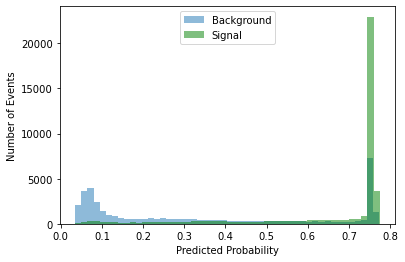

In [40]:
print(f'test labels are: {y_test[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions[y_test[:,0] == 0]
sig_preds = predictions[y_test[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
#plt.ylim(top=100)
#plt.show()
plt.savefig("bkgVsSig_v2.png")

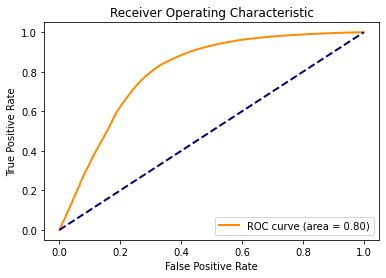

In [41]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
#plt.show()
plt.savefig("ROC_v2.png")

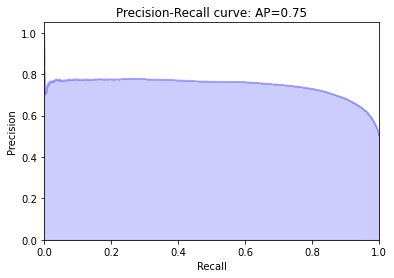

In [42]:
### precision recall curve
# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, predictions)
average_precision = average_precision_score(y_test, predictions)

# Plot precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [43]:
binary_prediction = predictions > 0.43

In [44]:
np.count_nonzero(binary_prediction == y_test)

59858

In [45]:
y_test.shape

(80000, 1)